<a href="https://colab.research.google.com/github/puneet-panwar/All_about_LSTMs/blob/main/System_identification_by_Aleksandar_Haber_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Using Recurrent Neural Networks and Keras/TensorFlow to Learn Input-Output Behaviour of Dynamical Systems by** [Aleksandar Haber](https://aleksandarhaber.com/using-recurrent-neural-networks-and-keras-tensorflow-to-learn-input-output-behaviour-of-dynamical-systems/)

## **Problem Formulation**

Various dynamical systems, such as robotic arms, oscillators, and even economic systems, can be mathematically described by a linearized state-space model having the following form:  
$$\dot{x}(t) = Ax(t) + Bu(t)$$
$$y(t) = Cx(t) + Du(t)$$
The vector **u** represents control inputs acting on the system. The vector **y** is the vector of observed variables, and the vector **x** is a state vector. Loosely speaking, this vector represents the internal system memory.


From a practical point of view, it is easier to estimate a discrete-time version of the original system. The discrete-time system has the following form:
$$x_{k+1} = Ax_k + Bu_k$$
$$y_k = Cx_k + Du_k$$

k is the discrete-time instant. t = kT, where T is the sampling period. 

The standard identification problem for the system can be formulated as follows:
- Given the sequence of the input-output data $${(u_0, y_0), (u_1, y_1),.....,(u_N, y_N)}$$
where N is the length of sequence, estimate the system matrices A,B,C,D up to (unknown) similarity transformation.
- The estimated state-space model should accurately reproduce the input-output behavior of the original system.
- The goal is to train (learn) the parameters of recurrent neural networks such that trained networks produce the input-output behavior of the discrete-time state-space model. That is, when we apply the sequence of control inputs $${u_0, u_1,...., u_N}$$ along with the initial state of the system to the NN, it should produce the sequence of outputs $$(\hat{y}_0, \hat{y}_1,.....,\hat{y}_N)$$  that accurately approximates the output sequence $$(y_0, y_1,....,y_N)$$ of the real-sytem.

In the sequel, we show how to perform this using the Keras/TensorFlow machine learning toolbox. For presentation clarity, this will be explained using an example of a mass-spring system.


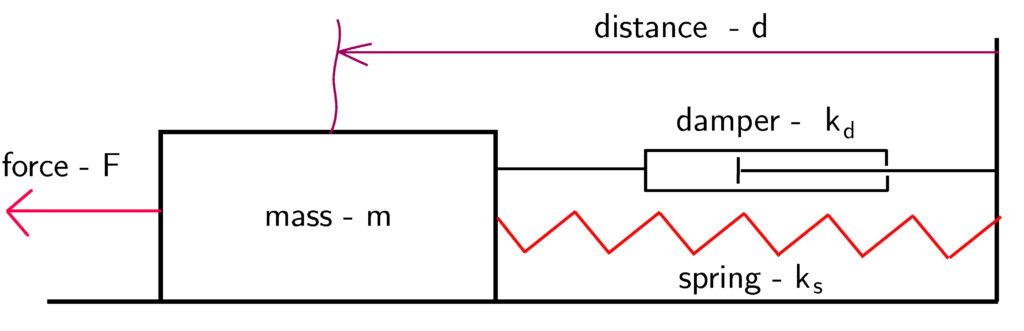

The mathematical model of mass-spring-damper system is given by: 
$$m\ddot{d} + k_d\dot{d} + k_sd = F$$
where d is the distance from the equilibrium point, m is the mass of the block. By introducing the state-space variables, $$x_1 = d \quad \text{and} \quad x_2 = \dot{d}$$ the model can be written in state-space form:


$$\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ -k_s/m & -k_d/m \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + \begin{bmatrix} 0 \\ 1/m \end{bmatrix} F$$
we assume that only the position vector d can be observed. Consequently, the output equation takes the following form:
$$y = \begin{bmatrix} 1 & 0 \end{bmatrix}x$$

To transform this continuous time-domain model into discrete-time model, we can use *Backward-Euler* method. $$ \frac{x_k - x_{k-1}}{h} = Ax_k + Bu_{k-1} $$ 
simplification of this equation leads to:
$$ x_k = \tilde{A}x_{k-1} + \tilde{B}u_{k-1}$$
where $$\tilde{A} = (I-hA)^{-1} \quad \text{and} \quad \tilde{B} = h\tilde{A}B $$
The output equation remails unchanged. 

Next, we present a Python code for computing the system response on the basis of the backward Euler method. The code will be used to generate training, validation, and test data for recurrent neural networks.

Here are a few comments about the code. 
- In lines 6-10. we define the system matrices and the initial condition (a random initial condition).
- Lines 13-14: we use 300 time steps, and a discretization step (sampling period) of 0.5 seconds.
Here it should be noted that the discretization step is relatively high, adding additional damping to the system discrete-time system.
Here we do not care about this phenomenon, and we consider the discrete-time system as a data generating system.
- In code line 18, we define a step function. Uncomment line 17, if you want to use a random signal as an input.
- Lines 30-49 define a function that simulates the dynamics and that returns the state and output sequences.

In [1]:
'''
from google.colab import drive
drive.mount('/content/gdrive')
%pwd
%cd /content/gdrive/MyDrive/my_repos
!git clone https://github.com/puneet-panwar/All_about_LSTMs
%cd ./All_about_LSTMs/
%pwd
'''

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\n%pwd\n%cd /content/gdrive/MyDrive/my_repos\n!git clone https://github.com/puneet-panwar/All_about_LSTMs\n%cd ./All_about_LSTMs/\n%pwd\n"

In [2]:
# to unmount drive
'''
from google.colab import drive
drive.flush_and_unmount()
'''

'\nfrom google.colab import drive\ndrive.flush_and_unmount()\n'

In [3]:
!git clone https://github.com/puneet-panwar/All_about_LSTMs
%cd All_about_LSTMs
%pwd

fatal: destination path 'All_about_LSTMs' already exists and is not an empty directory.
/content/All_about_LSTMs


'/content/All_about_LSTMs'

Text(0.5, 1.0, 'System step response')

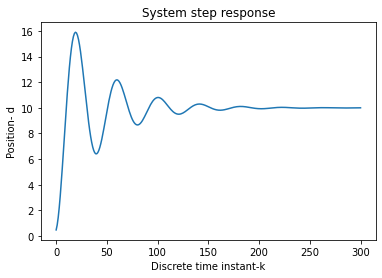

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil

# define the continuous-time system matrices
 
A=np.matrix([[0, 1],[- 0.1, -0.05]])
B=np.matrix([[0],[1]])
C=np.matrix([[1, 0]])
#define an initial state for simulation
x0=np.random.rand(2,1)
 
#define the number of time-samples used for the simulation and the sampling time for the discretization
time=300
sampling=0.5
 
#define an input sequence for the simulation
#input_seq=np.random.rand(time,1)
input_seq=np.ones(time)
#plt.plot(input_seq)
 
# the following function simulates the state-space model using the backward Euler method
# the input parameters are:
#    -- A,B,C              - continuous time system matrices 
#    -- initial_state      - the initial state of the system 
#    -- time_steps         - the total number of simulation time steps 
#    -- sampling_perios    - the sampling period for the backward Euler discretization 
# this function returns the state sequence and the output sequence
# they are stored in the vectors Xd and Yd respectively

def simulate(A,B,C,initial_state,input_sequence, time_steps,sampling_period):
    from numpy.linalg import inv
    I=np.identity(A.shape[0]) # this is an identity matrix
    # discretizing the continuous-time system
    Ad=inv(I-sampling_period*A) #sampling period = h 
    Bd=Ad*sampling_period*B
    Xd=np.zeros(shape=(A.shape[0],time_steps+1))
    Yd=np.zeros(shape=(C.shape[0],time_steps+1))
     
    for i in range(0,time_steps):
       if i==0:
           Xd[:,[i]]=initial_state
           Yd[:,[i]]=C*initial_state
           x=Ad*initial_state+Bd*input_sequence[i]
       else:
           Xd[:,[i]]=x
           Yd[:,[i]]=C*x
           x=Ad*x+Bd*input_sequence[i]
    Xd[:,[-1]]=x
    Yd[:,[-1]]=C*x
    return Xd, Yd
     
# calling 'simulate' function to compute the states and output of the system
state,output=simulate(A,B,C,x0,input_seq, time ,sampling)    
 
plt.plot(output[0,:])
plt.xlabel('Discrete time instant-k')
plt.ylabel('Position- d')
plt.title('System step response')

Next, we proceed with training the machine learning models. The following code defines a mass-spring model with arbitrary parameters and defines the discretization steps and the total number of time samples.

In [5]:
###############################################################################
#                   Model defintion
###############################################################################
 
# First, we need to define the system matrices of the state-space model:
# this is a continuous-time model, we will simulate it using the backward Euler method
A=np.matrix([[0, 1],[- 0.1, -0.000001]])
B=np.matrix([[0],[1]])
C=np.matrix([[1, 0]])
 
#define the number of time samples used for simulation and the discretization step (sampling)
time=200
sampling=0.5

- <font color='#DC88AB'> *To learn the model, we use a random input sequence.* </font> Furthermore, we use a random initial condition. Special care needs to be given to the definition of the training, validation, and test data. 

- According to the Keras documentation, recurrent neural networks take a tensor input of the following shape: “(batch_size, timesteps, input_features)”. In our case, batch_size=1, timesteps=time+1, and input_features=2.
If we denote the test input data by “testX”, then the entry “testX[0,:,:]” has the following form: $$textX[0,:,:] = \begin{bmatrix} {x_0}^(1) & {x_0}^(2) \\
u_0 & 0 \\ u_1 & 0 \\ . & . \\ . & . \\ u_{199} & 0 \end{bmatrix}$$

- First of all, in order to predict the system response, the model needs to “know” the initial state. This is why the first row of the above matrix is equal to the initial state.

- The entries on the first column, starting from the row 2 to the row 201 are the input sequence (the force applied to the model). 

- The corresponding entries on the second row are equal to zeros. This has been done in order to keep the sliced tensor dimension constant (Is there a better way to do this?). 

- The output, denoted by “output_train” in the code, is defined in the same manner.
The output shape is (1,201,1). 

- The first entry of the sliced output is x_{01} and the remaining entries are equal to the observed output sequence.

- Here for simplicity, we did not scale the training data. It should be emphasized that the inputs and outputs should not be scaled independently since they are related (special attention needs to be dedicated to the scaling or “detrending” problem).



## **Training, Validation and test data**

- For training, validation, and test data we use different initial states and input sequences. That is, for randomly generated input sequences and initial conditions, we simulate the system dynamics to obtain three different input-output data sets that are used for training, test, and validation. 

- This data is then used to form the input and output tensors. To define the training data, we simulate the system only once. 

- This is done because in real-life applications, it is time-consuming to observe the system dynamics for different inputs and initial conditions, and we often can do it only once by performing a single actuation and data collection experiment.

A Python code defining the training, validation, and test datasets, is given below.

In [6]:
%pwd

'/content/All_about_LSTMs'

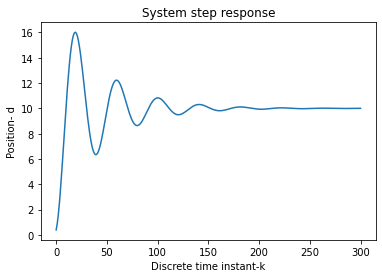

In [7]:
###############################################################################
#                  Create the training data
###############################################################################
#define an input sequence for the simulation
input_seq_train=np.random.rand(time,1)
#define an initial state for simulation
x0_train=np.random.rand(2,1)
 
 
# here we simulate the dynamics
from backward_euler import simulate
state,output_train=simulate(A,B,C,x0_train,input_seq_train, time ,sampling)    
 
output_train=output_train.T
# this is the output data used for training
output_train=np.reshape(output_train,(1,output_train.shape[0],1))
 
input_seq_train=np.reshape(input_seq_train,(input_seq_train.shape[0],1))
tmp_train=np.concatenate((input_seq_train, np.zeros(shape=(input_seq_train.shape[0],1))), axis=1)
tmp_train=np.concatenate((x0_train.T,tmp_train), axis=0)
# this is the input data used for training
trainX=np.reshape(tmp_train, (1,tmp_train.shape[0],tmp_train.shape[1]))
 
###############################################################################
#               Create the validation data
###############################################################################
# new random input sequence
input_seq_validate=np.random.rand(time,1)
# new random initial condition
x0_validate=np.random.rand(2,1)
 
# create a new ouput sequence by simulating the system 
state_validate,output_validate=simulate(A,B,C,x0_validate,input_seq_validate, time ,sampling)    
output_validate=output_validate.T
# this is the output data used for validation
output_validate=np.reshape(output_validate,(1,output_validate.shape[0],1))
 
input_seq_validate=np.reshape(input_seq_validate,(input_seq_validate.shape[0],1))
tmp_validate=np.concatenate((input_seq_validate, np.zeros(shape=(input_seq_validate.shape[0],1))), axis=1)
tmp_validate=np.concatenate((x0_validate.T,tmp_validate), axis=0)
# this is the input data used for validation
validateX=np.reshape(tmp_validate, (1,tmp_validate.shape[0],tmp_validate.shape[1]))
###############################################################################
#               Create the test data
###############################################################################
# new random input sequence
input_seq_test=np.random.rand(time,1)
# new random initial condition
x0_test=np.random.rand(2,1)
 
# create a new ouput sequence by simulating the system 
state_test,output_test=simulate(A,B,C,x0_test,input_seq_test, time ,sampling)    
output_test=output_test.T
# this is the output data used for test
output_test=np.reshape(output_test,(1,output_test.shape[0],1))
 
input_seq_test=np.reshape(input_seq_test,(input_seq_test.shape[0],1))
tmp_test=np.concatenate((input_seq_test, np.zeros(shape=(input_seq_test.shape[0],1))), axis=1)
tmp_test=np.concatenate((x0_test.T,tmp_test), axis=0)
# this is the input data used for test
testX=np.reshape(tmp_test, (1,tmp_test.shape[0],tmp_test.shape[1]))

## **Defining the Network**

Next, we define the networks. We will compare three network architectures: SimpleRNN, GRU, and LSTM. For brevity, we do not explain these network architectures.

In [8]:
%pwd

'/content/All_about_LSTMs'

In [9]:
!pip install keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
 
model_LSTM=Sequential()

#model.add(SimpleRNN(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))

#model.add(GRU(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))

model_LSTM.add(LSTM(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
#model.add(Dense(1))

model_LSTM.add(TimeDistributed(Dense(1)))  #there is no difference between this and model.add(Dense(1))...
# does not make sense to use metrics=['acc'], see https://stackoverflow.com/questions/41819457/zero-accuracy-training-a-neural-network-in-keras

model_LSTM.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])
 
model_LSTM.summary()

# after every epoch, we save the model, this is the absolute path on my C: drive, so the path is
# C:\python_files\system_identification\models\

# uncomment/comment following 3 lines to enable/disable storing weights after every epoch
#'''
# delete all the previous weights --> https://www.techiedelight.com/delete-all-files-directory-python/
dir = './model_weights_LSTM'
for files in os.listdir(dir):
    path = os.path.join(dir, files)
    try:
        shutil.rmtree(path)
    except OSError:
        os.remove(path)

#filepath="\\python_files\\system_identification\\models\\weights-{epoch:02d}-{val_loss:.6f}.hdf5"
filepath='./model_weights_LSTM/weights-{epoch:02d}-{val_loss:.6f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]
#'''

history=model_LSTM.fit(trainX, output_train , epochs=2000, batch_size=1, callbacks=callbacks_list, validation_data=(validateX,output_validate), verbose=2)
 

# load the model with the smallest validation loss
#model.load_weights("weights-1997-1.878475.hdf5")
 
# use the test data to predict the model response
testPredict_LSTM = model_LSTM.predict(testX)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 201, 32)           4480      
                                                                 
 time_distributed (TimeDistr  (None, 201, 1)           33        
 ibuted)                                                         
                                                                 
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
1/1 - 5s - loss: 25.5821 - mse: 25.5821 - val_loss: 26.6550 - val_mse: 26.6550 - 5s/epoch - 5s/step
Epoch 2/2000
1/1 - 0s - loss: 24.7748 - mse: 24.7748 - val_loss: 25.9921 - val_mse: 25.9921 - 164ms/epoch - 164ms/step
Epoch 3/2000
1/1 - 0s - loss: 24.1373 - mse: 24.1373 - val_loss: 25.3646 - val_mse: 25.3646 - 159ms/epoch - 159ms/step
Epoch 4/2000
1/1 - 0s - loss: 23.

A few comments about the code are in order:
- In code lines 11-13, we use the parameter “return_sequences=True”, because we want that the used RNN networks return the state sequence at every time sample (in total we have 201 time samples).
- Then, in code lines 22-24 we say to the compiler that we want to store the model (network parameters) after each epoch. The file names are
defined according to the validation loss. This has been done in order to retrieve the model with the smallest validation loss. This should be the “best” model, which should be tested using the test data.
- The commented line 29 loads the model with the best validation loss.
- In code line 32 we use the test data to generate the predicted output, which is then compared with the “true” test output obtained by simulating the original system.

The following code plots the predicted and “true” test data, and plots the training and validation losses with respect to the training epoch number.

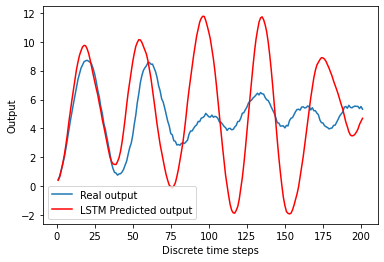

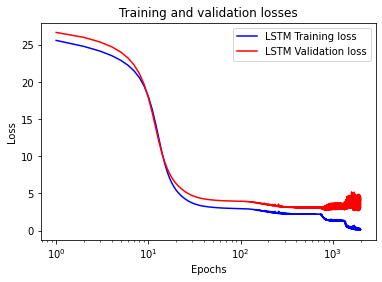

In [10]:
###############################################################################
#  Plot the LSTM predicted and "true" output and plot training and validation losses
###############################################################################
 
# plot the predicted and the "true" (test) outputs
time_plot=range(1,time+2)
plt.figure()
plt.plot(time_plot,testPredict_LSTM[0,:,0], label='Real output')
plt.plot(time_plot,output_test[0,:],'r', label='LSTM Predicted output')
plt.xlabel('Discrete time steps')
plt.ylabel('Output')
plt.legend()
plt.savefig('responseLSTM32.png')
plt.show()
 
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs, loss,'b', label='LSTM Training loss')
plt.plot(epochs, val_loss,'r', label='LSTM Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.savefig('lossLSTM32.png')
plt.show()

try for different number of units. (exercise)

We can see that we need a relatively high number of units (that is, the model order) to estimate the model. This is due to the two issues. First of all, we need to increase the number of epochs to obtain better results. Secondly, since the model is linear, we need to tell to Keras that we want to use linear activation functions and that we do not need bias. The following code achieves this:

In [16]:
model_RNN=Sequential()
model_RNN.add(SimpleRNN(2, input_shape=(trainX.shape[1],trainX.shape[2]),use_bias=False, activation='linear',return_sequences=True))
#model.add(GRU(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
#model.add(LSTM(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
#model.add(Dense(1))
 
model_RNN.add(Dense(1, activation='linear', use_bias=False))

model_RNN.summary()

#model.add(TimeDistributed(Dense(1,activation="linear",use_bias=False)))  #there is no difference between this and model.add(Dense(1))...
# does not make sense to use metrics=['acc'], see https://stackoverflow.com/questions/41819457/zero-accuracy-training-a-neural-network-in-keras
model_RNN.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])
# after every epoch, we save the model, this is the absolute path on my C: drive, so the path is
# C:\python_files\system_identification\models\
dir = './model_weights_RNN'
for files in os.listdir(dir):
    path = os.path.join(dir, files)
    try:
        shutil.rmtree(path)
    except OSError:
        os.remove(path)

#filepath="\\python_files\\system_identification\\models\\weights-{epoch:02d}-{val_loss:.6f}.hdf5"
filepath='./model_weights_RNN/weights-{epoch:02d}-{val_loss:.6f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]
history=model_RNN.fit(trainX, output_train , epochs=2000, batch_size=1, callbacks=callbacks_list, validation_data=(validateX,output_validate), verbose=0)

# use the test data to predict the model response
testPredict_RNN = model_RNN.predict(testX)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 201, 2)            8         
                                                                 
 dense_4 (Dense)             (None, 201, 1)            2         
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


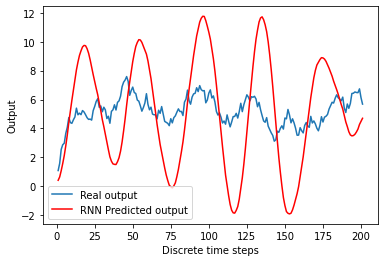

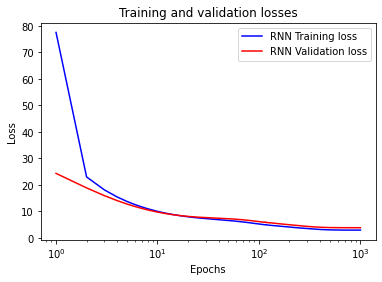

In [15]:
###############################################################################
#  Plot the RNN predicted and "true" output and plot training and validation losses
###############################################################################
 
# plot the predicted and the "true" (test) outputs
time_plot=range(1,time+2)
plt.figure()
plt.plot(time_plot,testPredict_RNN[0,:,0], label='Real output')
plt.plot(time_plot,output_test[0,:],'r', label='RNN Predicted output')
plt.xlabel('Discrete time steps')
plt.ylabel('Output')
plt.legend()
plt.savefig('responseRNN32.png')
plt.show()
 
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs, loss,'b', label='RNN Training loss')
plt.plot(epochs, val_loss,'r', label='RNN Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.savefig('lossRNN32.png')
plt.show()

## **Conclusion:**

We have explained how to use Keras/TensorFlow library to reproduce an input-output behavior of a dynamical system.
The main drawback of the present approach is that we need to know an initial condition to apply it. In practice, it is rarely the case that we know the initial condition of the system. One of the ways to overcome this is to simply ignore the initial condition since if the system is stable, the effect of the initial condition will fade away as time increases. Another approach is to reformulate the model we want to estimate and to try to estimate the model in the autoregressive with exogenous input form. This model predicts the system output only on the basis of the past inputs and outputs. 